In [47]:
import pandas as pd
import numpy as np
import os
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction as aF
from pathlib import Path

from pandas_ml import ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.decomposition import PCA 

from scipy.stats import kurtosis, skew

from itertools import product

In [48]:
path_data = Path('../data/')
df_labels = labels = pd.read_csv(path_data/'ComParE2018_AtypicalAffect.txt', sep="\t")
df_labels['subset'] = df_labels['file_name'].str.split('_').apply(lambda x: x[0])
df_labels.head()


# & 
#                                    (df_labels['emotion'] == 'neutral')
X_train, y_train = ((df_labels.loc[(df_labels['subset']=='train')][['file_name']]), 
                    df_labels.loc[df_labels['subset']=='train']['emotion'])

X_devel, y_devel = (df_labels.loc[df_labels['subset']=='devel'][['file_name']], 
                    df_labels.loc[df_labels['subset']=='devel']['emotion'])

#train and development
X_train_all, y_train_all = (pd.concat([X_train, X_devel], axis=0).reset_index(), 
                            pd.concat([y_train, y_devel], axis=0).reset_index())


X_test, y_test = (df_labels.loc[df_labels['subset']=='test'][['file_name']], 
                    df_labels.loc[df_labels['subset']=='test']['emotion'])

X_train_all.head(), y_train_all.head()

(   index       file_name
 0      0  train_0001.wav
 1      1  train_0002.wav
 2      2  train_0003.wav
 3      3  train_0004.wav
 4      4  train_0005.wav,    index  emotion
 0      0  neutral
 1      1  neutral
 2      2  neutral
 3      3  neutral
 4      4  neutral)

In [49]:
class ReadRawData(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_c = X.copy()
        df_sample_data = X_c['file_name'].apply(lambda x: audioBasicIO.readAudioFile(path_data/'wav'/x))
        X_c['sample_rate'] = df_sample_data.apply(lambda x: x[0])
        X_c['raw_data'] = df_sample_data.apply(lambda x: x[1])
        X_c['duration'] = X_c['raw_data'].apply(lambda x: x.size)/X_c['sample_rate']
        return X_c
        
rrd = ReadRawData()
X_train = rrd.fit_transform(X_train)
X_devel =rrd.transform(X_devel)
X_train_all = rrd.fit_transform(X_train_all)
X_test =rrd.transform(X_test)
X_train_all.head()

,index,file_name,sample_rate,raw_data,duration
0,0,train_0001.wav,16000,"[8, -16, -121, -137, -27, 25, -6, -85, -84, 13...",2.149812
1,1,train_0002.wav,16000,"[364, 614, 507, 569, 466, 485, 458, 422, 401, ...",1.263750
2,2,train_0003.wav,16000,"[-15, -17, 21, 14, 18, 25, 22, 45, 49, 22, 27,...",0.817125
3,3,train_0004.wav,16000,"[-819, -1333, -1253, -1463, -1517, -1561, -164...",0.758125
4,4,train_0005.wav,16000,"[-100, -67, -311, -415, -351, -369, -362, -302...",0.770312


In [50]:
class PyAudioAnalysisFeaturesFactory(BaseEstimator, TransformerMixin):
    
    def __init__(self, 
                 limit_to=4, #parameter to control where to truncate (or pad)
                 pad=['resize', 'zero', 'mean', 'stat'][0], # what kind of padding to use
                 frame_size=0.05, #PyAudio default
                 frame_step=0.025,#PyAudio default
                 keep_duration=True, #to keep duration as a feature
                 print_every=50
                ):
        self.limit_to, self.pad = limit_to, pad
        self.frame_size, self.frame_step = frame_size, frame_step
        self.keep_duration = keep_duration
        self.key = f'{limit_to}_{pad}_{frame_size}_{frame_step}_{keep_duration}'
        self.counter, self.print_every = 0, print_every

    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X_c = X.copy()
        if self.pad == 'stat':
            features = X_c.apply(lambda x: self.add_features_functionals((x['sample_rate'], 
                                                                          x['raw_data'])), 
                                 axis=1)
            features = pd.DataFrame(features.values.tolist())
        else:
            features = X_c.apply(lambda x: self.add_features((x['sample_rate'], x['raw_data'])), axis=1)
            # these steps are just for getting the column names
            x = X_c['raw_data'].iloc[0]
            fs = X_c['sample_rate'].iloc[0]
            s, t = aF.stFeatureExtraction(np.resize(x,(fs*self.limit_to,)),
                                          fs,
                                          self.frame_size*fs,
                                          self.frame_step*fs)
            col_names = np.array([f'{name}_{i}' for i in range(s.shape[1]) for name in t]).reshape(-1)
            features = pd.DataFrame(features.values.tolist(), columns=col_names)
        
        if self.keep_duration:
            features['duration'] = X_c['duration']
        return features.astype(np.float32)
            
            
    def add_features(self, res):
        if self.counter%self.print_every == 0:
            print(self.counter)
        self.counter += 1
        fs,x = res
        diff = (self.limit_to*fs)-x.shape[0]
        if self.pad == 'resize':
            x = np.resize(x,(fs*self.limit_to,))
        elif self.pad == 'zero':
            x = np.hstack([np.zeros(diff), x]) if diff>0 else x[:(self.limit_to*fs)]
        else:
            x = np.hstack([np.repeat(x.mean(), diff), x]) if diff>0 else x[:(self.limit_to*fs)]
            
        s,t = aF.stFeatureExtraction(x,fs,self.frame_size*fs,self.frame_step*fs)
        s = s.T.reshape(-1)
        return s
    
    def add_features_functionals(self, res):
        if self.counter%self.print_every == 0:
            print(self.counter)
        self.counter += 1
        fs,x = res
        s,t = aF.stFeatureExtraction(x,fs,self.frame_size*fs,self.frame_step*fs)
        summarized_functionals = np.hstack([
            s.mean(axis=1), 
            s.min(axis=1), 
            s.max(axis=1), 
            s.std(axis=1),
            s.var(axis=1),
            skew(s, axis=1),
            kurtosis(s, axis=1)
            
        ])
        return summarized_functionals
    

In [ ]:
feature_transform_params = {
    'limit_to': [2, 4, 6],
    'pad': ['resize', 'zero', 'mean']
}



feature_transform_param_combs = [dict(zip(feature_transform_params.keys(),v))
                                 for v in product(*feature_transform_params.values())]
    

feature_dict = dict()

for i in feature_transform_param_combs:
    print(i)
    paaff = PyAudioAnalysisFeaturesFactory(**i)
    feature_dict[paaff.key] = paaff.fit_transform(X_train_all)

paaff = PyAudioAnalysisFeaturesFactory(pad='stat')
feature_dict[paaff.key] = paaff.fit_transform(X_train_all)


In [52]:
paaff = PyAudioAnalysisFeaturesFactory(pad='stat')
X_train_transformed = paaff.fit_transform(X_train)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300


In [53]:
X_test_transformed = paaff.fit_transform(X_test)

3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300


In [78]:
X_train_transformed.to_csv('')

,0,1,2,3,4,5,6,7,8,9,...,229,230,231,232,233,234,235,236,237,duration
0,0.117811,0.004433,2.986691,0.209806,0.194530,0.951155,0.004958,0.222381,-27.121483,2.069960,...,-0.797892,3.801740,1.922332,5.558456,5.935714,5.941865,0.190979,2.354362,-0.776206,2.149812
1,0.131951,0.036254,3.111180,0.274072,0.267338,0.853494,0.003891,0.224031,-25.022964,1.981063,...,0.380650,10.381280,7.629863,5.288845,13.403562,0.464534,1.870302,0.242955,-0.568696,1.263750
2,0.084178,0.036550,2.994169,0.175453,0.204855,0.297038,0.010029,0.100242,-27.777719,2.830936,...,5.839707,1.187667,1.404901,5.112379,4.319216,19.135752,0.133401,6.267524,0.580655,0.817125
3,0.126063,0.035704,3.135772,0.217019,0.191338,1.126078,0.005424,0.252672,-24.285065,1.455326,...,1.903091,1.181816,1.185475,-0.563251,11.923958,9.067728,11.535688,10.658661,1.016779,0.758125
4,0.136679,0.030518,3.096220,0.258006,0.251982,1.053883,0.004471,0.277672,-26.262537,1.761756,...,19.785889,2.831229,-0.945520,2.963851,3.714022,5.439431,1.167632,4.525349,0.215417,0.770312
5,0.103340,0.022406,3.047500,0.196435,0.194915,0.819973,0.007283,0.167511,-27.100079,1.816935,...,5.410297,29.852295,16.829998,19.768669,15.718943,11.225268,20.700907,15.310120,0.526525,5.880938
6,0.092726,0.046004,3.114616,0.209899,0.233034,0.516097,0.007273,0.124461,-24.629271,2.423477,...,4.345770,16.597397,9.004042,7.519061,7.170671,13.942981,4.849928,44.790524,0.139212,2.575625
7,0.127292,0.008108,3.010084,0.208747,0.200464,0.957155,0.006004,0.199468,-27.188696,2.091696,...,2.125708,13.317750,4.990618,40.589745,12.678111,12.631898,1.111800,10.290594,-0.292221,5.922750
8,0.095589,0.008935,3.012142,0.192401,0.211937,0.627345,0.006240,0.135434,-27.456678,2.696172,...,-0.801389,21.114738,4.471363,10.615147,14.122800,2.931160,0.847569,26.910156,-0.422247,13.551500
9,0.104487,0.055557,3.088410,0.222982,0.234183,0.677148,0.007099,0.153308,-26.651756,2.058745,...,25.147488,23.124388,0.384754,26.771923,2.571888,3.704568,3.908759,5.926441,-0.371021,2.515438


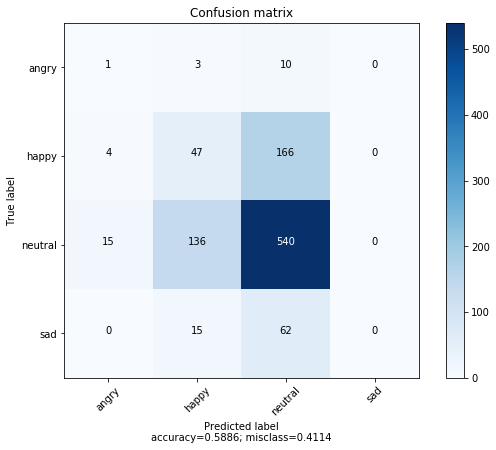

<function confusion_matrix at 0x7fd4a01b1268>

               precision    recall  f1-score   support

       angry       0.05      0.07      0.06        14
       happy       0.23      0.22      0.22       217
     neutral       0.69      0.78      0.74       691
         sad       0.00      0.00      0.00        77

   micro avg       0.59      0.59      0.59       999
   macro avg       0.24      0.27      0.25       999
weighted avg       0.53      0.59      0.56       999

0.5885885885885885


/home/gurudev/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gurudev/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gurudev/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
from sklearn import tree

model = AdaBoostClassifier(DecisionTreeClassifier(class_weight={'neutral': .01, 
                                                               'happy': .1, 
                                                               'sad': 1000, 
                                                               'angry':10000}), 
                                 n_estimators=100, learning_rate=100.0)
model.fit(X_train_transformed.drop('duration', axis=1),y_train)
y_predtree = model.predict(X_test_transformed.drop('duration', axis=1))
reporting(y_test,y_predtree)

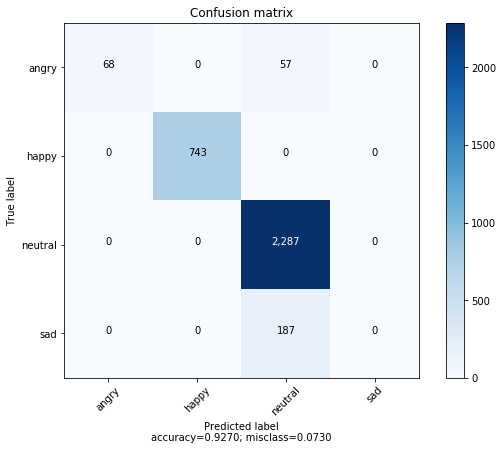

<function confusion_matrix at 0x7fd4a01b1268>

               precision    recall  f1-score   support

       angry       1.00      0.54      0.70       125
       happy       1.00      1.00      1.00       743
     neutral       0.90      1.00      0.95      2287
         sad       0.00      0.00      0.00       187

   micro avg       0.93      0.93      0.93      3342
   macro avg       0.73      0.64      0.66      3342
weighted avg       0.88      0.93      0.90      3342

0.9269898264512269


/home/gurudev/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gurudev/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/gurudev/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
y_predtree = model.predict(X_train_transformed.drop('duration', axis=1))
reporting(y_train,y_predtree)

In [81]:
# storing the dictionary for future use

print(feature_dict.keys())

with open(path_data/'feature_dict.pickle', 'wb') as handle:
    pickle.dump(feature_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open(path_data/'filename.pickle', 'rb') as handle:
#     feature_dict = pickle.load(handle)


# paf = PyAudioAnalysisFeatures()
# X_train = paf.transform(X_train)
# X_devel = paf.transform(X_devel)
# X_test = paf.transform(X_test)

# X_train.to_csv(path_data/'train_4-sec.csv')
# X_test.to_csv(path_data/'test_4-sec.csv')
# X_devel.to_csv(path_data/'devel_4-sec.csv')

# X_train = pd.read_csv(path_data/'train_4-sec.csv')
# X_test = pd.read_csv(path_data/'test_4-sec.csv')
# X_devel = pd.read_csv(path_data/'devel_4-sec.csv')


dict_keys(['2_resize_0.05_0.025_True', '2_zero_0.05_0.025_True', '2_mean_0.05_0.025_True', '4_resize_0.05_0.025_True', '4_zero_0.05_0.025_True', '4_mean_0.05_0.025_True', '6_resize_0.05_0.025_True', '6_zero_0.05_0.025_True', '6_mean_0.05_0.025_True'])

In [86]:
class PyAudioAnalysisFeatures(PyAudioAnalysisFeaturesFactory, BaseEstimator, TransformerMixin):
    
    def __init__(self, **kwargs):
        PyAudioAnalysisFeaturesFactory.__init__(self, **kwargs)
        
    def fit(self):
        return self
    
    def transform(self, X):
        X_base = feature_dict[self.key]
        return X_base.loc[X.index]

In [87]:
PyAudioAnalysisFeatures().transform(X_train.loc[[0,2,4]])

,zcr_0,energy_0,energy_entropy_0,spectral_centroid_0,spectral_spread_0,spectral_entropy_0,spectral_flux_0,spectral_rolloff_0,mfcc_1_0,mfcc_2_0,...,chroma_5_158,chroma_6_158,chroma_7_158,chroma_8_158,chroma_9_158,chroma_10_158,chroma_11_158,chroma_12_158,chroma_std_158,duration
0,0.227785,0.329161,0.456821,0.480601,0.488110,0.481852,0.401752,0.215269,0.101377,0.103880,...,0.020262,0.018331,0.019932,0.035767,0.031810,0.024497,0.028909,0.038841,0.039237,2.149812
2,0.075094,0.072591,0.092616,0.147685,0.200250,0.125156,0.052566,0.061327,0.060075,0.055069,...,0.015770,0.018118,0.031636,0.040933,0.051808,0.070929,0.050378,0.034263,0.028873,0.817125
4,0.125156,0.200250,0.245307,0.161452,0.077597,0.087610,0.106383,0.105131,0.071339,0.058824,...,0.058274,0.069391,0.061403,0.034582,0.050379,0.015063,0.019894,0.033224,0.041645,0.770312


In [30]:
model_pipeline = pipeline.Pipeline([
    ('features', PyAudioAnalysisFeatures()),
    ('pca', PCA(n_components=500)),
    ('model', AdaBoostClassifier(DecisionTreeClassifier(class_weight={'neutral': 100000, 
                                                                      'happy': 100, 
                                                                      'sad': 1, 
                                                                      'angry':1}), 
                                 n_estimators=100, learning_rate=10.0))
])

param_grid = {
    'pca__n_components': [15, 50, 100, 250, 500],
    'model__class_weight': [
                        {'neutral': 1, 'happy': 1, 'sad': 100000, 'angry':100000},
                        {'neutral': 100000, 'happy': 100000, 'sad': 1, 'angry':1}
                    ],
    'model__learning_rate': [0.1, 1, 10.0]
}

for k,v in feature_transform_params:
    param_grid['features__'+k] = v
    
# custom scoring - Unweighted Average Recall (from the paper),  
# because our data is imbalanced
uar = make_scorer(recall_score, average='macro')

model_pipeline_cv = GridSearchCV(
    estimator= model_pipeline, #use the model
    param_grid=param_grid, # generate combinations from the parameter grid
    scoring=uar, #UAR to pick the best params
    n_jobs=4, # use these many cores for faster parallel processing
    cv=5, # k fold cv
    refit=True, # refit the best parameters on all of the data
    verbose=50, #give detailed progress
    iid=True)

model_pipeline_cv.fit(X_train_all, y_train_all)

KeyboardInterrupt: 

In [54]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def reporting(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, target_names=np.unique(y_train))
    print(confusion_matrix)
    print("\n",classification_report(y_test,y_pred))
    print(accuracy_score(y_test,y_pred))

In [ ]:
y_pred = model_pipeline.predict(X_test)

In [ ]:
reporting(y_test,y_pred)

In [ ]:
classification_report(y_test,y_pred)